In [1]:
# Start
import os
import time
print("last time run: {}".format(time.strftime("%c")))
CWD = os.getcwd()
print("Current working dir: {}".format(CWD))

last time run: Sat Mar 30 12:13:29 2019
Current working dir: /home/bren/Home/projects/Second Harvest Data Dive 20190329-30


In [2]:
# Style
from IPython.core.display  import HTML
from IPython.core.debugger import set_trace


def css_styling():
    styles = open("/home/bren/Home/python/Jupyter/Jupyter Notebooks/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
# TOC Setup
import sys
toc_path = "/home/bren/miniconda3/lib/python3.7/site-packages/IPythonTOC-1.2.0-py3.7.egg"
if toc_path not in sys.path:
    sys.path.append(toc_path)
else:
    print("toc_path in sys.path already")

from IPythonTOC import IPythonTOC
toc = IPythonTOC()

toc_path in sys.path already


## Table of Contents
<a id="Table_of_Contents"></a> 

[Pallet Audit and Line](#Pallet_Audit_and_Line)
* Pareto percentages of location

[Item Master](#Item_Master) 
* Pareto Curve for product category up to 0.95 of items

[Bin Transactions](#Bin_Transactions)
* Histogram of Transactions per Month

[Inventory Transactions](#Inventory_Transactions)
* Histogram of Transactions per Month

[Order Header](#Order_Header)
* Pareto Curve for bill_to_name (customers / vendors?)
* Histogram of bill_to_city

[Order Line](#Order_Line_Details)
* 139,387 lines
* 58 items constitute 80.0% of orders and 18.4% of item
* Pareto Curve of 'item_no' up to 70% of items ordered (80% makes x axis even less clear)
* day of week
* Interesting Questions:
    * holidays, long weekends
    * order completion status as function of location of items - see Frank
    * interesting questions going further
    * Order independence
    * data cleaning

[Customer and Vendor info](#Customer_and_Vendor_info)
* Not sure this is important for the problem we're attempting to address

[Item Inventory by Bin and Location](#Item_Inventory_by_Bin_and_Location)
* Not sure this is important for the problem we're attempting to address

[Item Inventory by Location](#Item_Inventory_by_Location)
* Not sure this is important for the problem we're attempting to address

[Location Description](#Location_Description)
* Not sure this is important for the problem we're attempting to address



In [4]:
# imports
from matplotlib import pyplot as plt, rcParams
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns',500)
sns.set_style('whitegrid')

%matplotlib inline
plt.style.use("ggplot")
rcParams["figure.figsize"] = (14, 7)

import IPython, platform
%reload_ext watermark
print("Python  {}".format(platform.python_version()))
%watermark -v -m -p IPython,matplotlib,numpy,pandas,seaborn

Python  3.7.1
CPython 3.7.1
IPython 7.1.1

IPython 7.1.1
matplotlib 3.0.2
numpy 1.16.1
pandas 0.23.4
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.9.0-8-amd64
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit


In [5]:
def calcPareto(df, key_col):
    hv = df[key_col].value_counts()
    count_col = 'counter'
    pareto = pd.DataFrame(np.array([(k, int(v)) for k,v in hv.items()]),
                                columns=[key_col, count_col]).set_index(key_col, drop=True)
    pareto[count_col] = pareto[count_col].astype(int)
    pareto['pct_count'] = pareto[count_col] / pareto[count_col].sum()
    pareto['cum_pct'] = pareto.pct_count.cumsum()
    return pareto


In [6]:
def plotPareto(df, key_col, max_pct=0.85):
    from matplotlib.ticker import PercentFormatter
    from matplotlib import rcParams
    
    plt.style.use("ggplot")
    rcParams["figure.figsize"] = (14, 7)

    pareto = calcPareto(df, key_col)
    mask = pareto.cum_pct <= max_pct
    
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    ax.bar(pareto.index[mask], pareto.counter[mask], color="C0")
    ax2 = ax.twinx()
    ax2.plot(pareto.index[mask], pareto.cum_pct[mask], color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.title('Pareto for {}, max pct = {:.2%}'.format(key_col, max_pct),
              fontsize=18, loc='center')
    plt.show()


## Pallet Audit and Line
<a id='Pallet_Audit_and_Line'></a>


[Table of Contents](#Table_of_Contents)

In [7]:
df_pallet = pd.read_csv('data/PalletAuditandLine.csv', index_col = None, header = 0, low_memory=False)

In [8]:
df_pallet.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540101 entries, 0 to 5540100
Data columns (total 13 columns):
PKG_ID        object
Item_no       object
Item_desc     object
Loc           object
Qty           float64
Weight        float64
created_tm    object
aud_tm_x      object
aud_action    object
PKG_No        int64
Bin_no        object
aud_dt        object
aud_tm_y      object
dtypes: float64(2), int64(1), object(10)
memory usage: 549.5+ MB


In [9]:
df_pallet.isna().sum(axis=0)

PKG_ID             0
Item_no            0
Item_desc          0
Loc                0
Qty                0
Weight             0
created_tm         0
aud_tm_x           0
aud_action         0
PKG_No             0
Bin_no        697175
aud_dt             0
aud_tm_y           0
dtype: int64

In [10]:
df_pallet.nunique()

PKG_ID        111669
Item_no         2052
Item_desc       1842
Loc                9
Qty             2579
Weight          3777
created_tm     33813
aud_tm_x       35999
aud_action         4
PKG_No        111669
Bin_no          3751
aud_dt           912
aud_tm_y      790397
dtype: int64

In [11]:
pareto = calcPareto(df_pallet, 'Loc')
pareto

,counter,pct_count,cum_pct
Loc,,,
1,4593625,0.829159,0.829159
3,724844,0.130836,0.959995
86,133270,0.024056,0.984050
101,28270,0.005103,0.989153
300,26040,0.004700,0.993854
406,18705,0.003376,0.997230
4,8889,0.001604,0.998834
105,5572,0.001006,0.999840
TRN,886,0.000160,1.000000


In [12]:
df_pallet.head(3)

,PKG_ID,Item_no,Item_desc,Loc,Qty,Weight,created_tm,aud_tm_x,aud_action,PKG_No,Bin_no,aud_dt,aud_tm_y
0,2F916A20-5F8C-41FA-8979-6D9A02E49D01,5311MTT,"Vegetables Canned, Asst.",1,36.0,720.0,44:53.6,44:53.6,A,203808,NaN,2018-11-19 00:00:00.000,1900-01-01 11:16:53.210
1,2F916A20-5F8C-41FA-8979-6D9A02E49D01,5311MTT,"Vegetables Canned, Asst.",1,36.0,720.0,44:53.6,44:53.6,A,203808,NaN,2018-11-20 00:00:00.000,1900-01-01 07:53:05.520
2,2F916A20-5F8C-41FA-8979-6D9A02E49D01,5311MTT,"Vegetables Canned, Asst.",1,36.0,720.0,44:53.6,44:53.6,A,203808,CA,2018-11-20 00:00:00.000,1900-01-01 07:53:05.523


In [13]:
#df_pallet.to_csv('processed/PalletAuditandLine.csv', index=False)

In [14]:
del df_pallet

## Item Master
<a id='Item_Master'></a>


[Table of Contents](#Table_of_Contents)

In [15]:
df_dditemmaster = pd.read_csv('data/DD_ItemMaster.csv', index_col = None, header = 0, low_memory=False)

In [16]:
df_dditemmaster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15165 entries, 0 to 15164
Columns: 154 entries, item_no to Unnamed: 153
dtypes: float64(57), object(97)
memory usage: 17.8+ MB


In [17]:
df_dditemmaster.head()

,item_no,search_desc,item_desc_1,item_desc_2,prod_cat,loc,uom,price_uom,price_ratio,pur_uom,pur_to_inv_ratio,mfg_uom,mfg_to_inv_ratio,item_weight_uom,item_weight,yield_pct,bkord_fg,tax_fg,end_item_cd,kit_feat_fg,kit_prc_rollup,feature_prc_opt,kit_cst_rollup,mat_cost_type,p_and_ic_cd,activity_cd,activity_dt,stocked_fg,controlled_fg,pur_or_mfg,ms_item_fg,commodity_cd,byr_plnr,mrp_stat_item,last_item_revision,lec_revision,lec_dt,consumed_fg,mrp_min_ord,mrp_safety_stk,mrp_ord_up_to,planning_lead_tm,fix_var_ld_tm_fac,approved_vend_req,drawing_release_no,drawing_revision_no,rtg_release_no,rtg_revision_no,rtg_no,ord_policy_cd,planning_prd,planning_ord_mult,mrp_tm_fence_shop,lot_size,stk_stat_cd,low_lvl_cd,comm_pct_amt,calc_comm_tp,ser_lot_fg,cad_drawing_name,shelf_life_days,ser_warranty_days,inspection_cd,qty_pct_to_inspect,upc_cd,trx_aud_fg,group_tech_cd,cube_width_uom,cube_length_uom,cube_height_uom,cube_width,cube_length,cube_height,cube_qty_per,item_note_1,item_note_2,item_note_3,item_note_4,item_note_5,user_dt,user_amt,user_def_fld_1,user_def_fld_2,user_def_fld_3,user_def_fld_4,user_def_fld_5,user_def_cd,user_fld_6,user_fld_7,user_fld_8,user_fld_9,user_fld_10,user_fld_11,user_fld_12,user_fld_13,user_14_date,user_15_date,user_16_date,user_fld_17,user_fld_18,user_fld_19,user_fld_20,landed_cost_cd,landed_cost_cd_2,landed_cost_cd_3,landed_cost_cd_4,landed_cost_cd_5,landed_cost_cd_6,landed_cost_cd_7,landed_cost_cd_8,landed_cost_cd_9,landed_cost_cd_10,mfg_method,forced_demand,var_lead_tm,comm_cd,country_origin,web_item,po_req_fg,po_req_consolidate,create_po,bol_code,sl_static_length,sl_static_value,sl_numeric_length,sl_numeric_value,default_rec_loc,force_ecm_fg,doc_field_1,doc_field_2,doc_field_3,extra_1,extra_2,extra_3,extra_4,extra_5,extra_6,extra_7,extra_8,extra_9,extra_10,extra_11,extra_12,extra_13,extra_14,extra_15,filler_0002,ID,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153
0,1,NASH TABLE CORRUGATION,Nash Table Corrugation,250/pallet,1,1,EA,EA,1,EA,1,EA,1,CS,250,0,N,N,NaN,NaN,N,N,N,SUP,DRY,O,00:00.0,Y,Y,P,N,NONE,0,N,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,A,N,NaN,NaN,NaN,NaN,0,NONE,Y,NaN,NaN,NaN,NaN,0,0,0.0,0.0,NaN,DR,NaN,NaN,NaN,NaN,0,NaN,N ...,NaN,NaN,NaN,N,NaN,NaN,0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OE,NaN,NaN,NaN,NaN,N,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12333.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,CREAMETTE SPAGHETTI,Creamette Spaghetti,24-7 oz,21,1,EA,EA,1,EA,1,EA,1,LB,11,0,N,N,NaN,NaN,N,N,N,FRD,DRY,A,00:00.0,Y,Y,P,N,FR,0,N,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,A,N,NaN,NaN,NaN,NaN,0,NONE,Y,NaN,NaN,NaN,NaN,0,0,0.0,0.0,,DR,Local,24,7 oz,NaN,0,0,N ...,...,Yellow ...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OE,NaN,NaN,NaN,NaN,N,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,611.0,NaN,NaN,NaN,NaN,NaN,NaN
2,28,SUN CHIPS FRENCH ONION,Sun Chips French Onion,65-1.5oz,25,1,EA,EA,1,EA,1,EA,1,CS,7,0,N,N,NaN,NaN,N,N,N,FRD,DRY,O,00:00.0,Y,Y,P,N,OPEN,0,N,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,A,N,NaN,NaN,NaN,NaN,0,NONE,Y,NaN,NaN,NaN,NaN,0,0,0.0,0.0,,DR,Blue,NaN,NaN,NaN,0,...,N ...,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OE,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12508.0,NaN,NaN,NaN,NaN,NaN,NaN
3,30,LIQUID PLUMMER,Liquid Plummer,4-1 gal,1,1,EA,EA,1,EA,1,EA,1,CS,38,0,N,N,NaN,NaN,N,N,N,FRD,DRY,O,00:00.0,Y,Y,P,N,FR,0,N,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,A,N,NaN,NaN,NaN,NaN,0,NONE,Y,NaN,NaN,NaN,NaN,0,0,0.0,0.0,,DR,B

In [18]:
df_itemmaster = pd.read_csv('data/DR_ItemMaster.csv', index_col = None, header = 0, low_memory=False)
df_itemmaster.drop(['commodity_cd'], axis=1, inplace=True)
rename_dict = dict([('user_def_fld_4', 'food_pyramid')])
rename_dict
df_itemmaster.rename(columns=rename_dict, inplace=True)

In [19]:
df_itemmaster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3437 entries, 0 to 3436
Data columns (total 13 columns):
item_no            3437 non-null object
item_desc_1        3437 non-null object
item_desc_2        3424 non-null object
prod_cat           3437 non-null object
uom                3436 non-null object
item_weight_uom    3420 non-null object
item_weight        3437 non-null float64
p_and_ic_cd        3153 non-null object
item_note_3        1620 non-null object
item_note_4        2935 non-null object
item_note_5        3393 non-null object
food_pyramid       3259 non-null object
ID                 3437 non-null int64
dtypes: float64(1), int64(1), object(11)
memory usage: 349.1+ KB


In [20]:
df_itemmaster.prod_cat.unique()

array(['21 ', 'P23', '27 ', '01 ', '26 ', '03 ', '14 ', '23 ', 'P12',
       '25 ', '04 ', 'P07', 'P01', '05 ', '12 ', '02 ', 'P05', '19 ',
       '10 ', '08 ', '06 ', '16 ', 'P27', 'P10', '13 ', '31 ', '24 ',
       'P06', '11 ', 'P25', 'P26', '07 ', '30 ', 'P02', 'P21', 'P13',
       '15 ', '28 ', 'P20', 'P19', 'P24', '18 ', 'P11', '09 ', '35 ',
       '33 ', 'P16', 'P15', 'P08', 'P09', '17 ', 'P18', 'P04', '20 ',
       'P14', '32 '], dtype=object)

In [21]:
df_itemmaster.columns

Index(['item_no', 'item_desc_1', 'item_desc_2', 'prod_cat', 'uom',
       'item_weight_uom', 'item_weight', 'p_and_ic_cd', 'item_note_3',
       'item_note_4', 'item_note_5', 'food_pyramid', 'ID'],
      dtype='object')

In [22]:
imnan = df_itemmaster[df_itemmaster.p_and_ic_cd.isna()]
len(imnan.item_desc_2.unique())

243

In [23]:
df_itemmaster.nunique()

item_no            3437
item_desc_1        2894
item_desc_2        2232
prod_cat             56
uom                   4
item_weight_uom       3
item_weight         661
p_and_ic_cd           4
item_note_3           7
item_note_4         142
item_note_5        1695
food_pyramid          4
ID                 3437
dtype: int64

In [24]:
df_itemmaster.head(3)

,item_no,item_desc_1,item_desc_2,prod_cat,uom,item_weight_uom,item_weight,p_and_ic_cd,item_note_3,item_note_4,item_note_5,food_pyramid,ID
0,000002,Creamette Spaghetti,24-7 oz,21,EA,LB,11.0,DRY,Local,24,7 oz,Yellow ...,611
1,000020OA,Co-Op Pork and Beans 16 oz,24/16 oz,P23,EA,LB,29.0,DRY,Purchased,24,16 oz,Green ...,1644
2,00009,ING Diced Tomatoes,55 gal drum,27,EA,LB,440.0,DRY,NaN,NaN,55 gal drum,Green ...,715


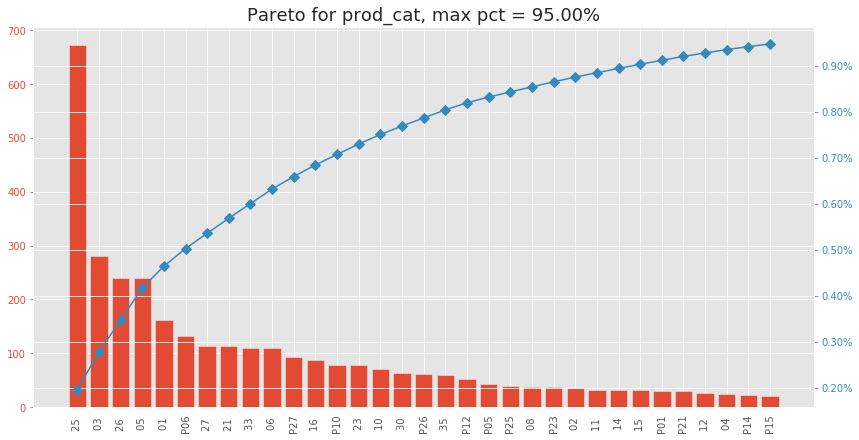

In [25]:
plotPareto(df_itemmaster, 'prod_cat', max_pct=0.95)


In [26]:
#df_itemmaster.to_csv('processed/ItemMaster.csv', index=False)

In [27]:
try:
    del df_itemmaster
except:
    pass
try:
    del df_dditemmaster
except:
    pass
try:
    del imnan
except:
    pass


## Bin Transactions
<a id='Bin_Transactions'></a>


[Table of Contents](#Table_of_Contents)

In [28]:
df_bintrans = pd.read_csv('data/BinTransactions.csv', index_col = None, header = 0, low_memory=False)

In [29]:
df_bintrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357008 entries, 0 to 1357007
Data columns (total 7 columns):
ord_no     1357008 non-null int64
bin_no     1357008 non-null object
item_no    1357008 non-null object
trx_dt     1357008 non-null object
year       1357008 non-null int64
month      1357008 non-null int64
day        1357008 non-null int64
dtypes: int64(4), object(3)
memory usage: 72.5+ MB


In [30]:
df_bintrans.head(3)

,ord_no,bin_no,item_no,trx_dt,year,month,day
0,1947879,SHIP,1403181,2016-06-30,2016,6,30
1,1947880,$J22A,76150OA,2016-06-30,2016,6,30
2,1947881,%SHIP,1403181,2016-06-30,2016,6,30


In [31]:
df_bintrans.nunique()

ord_no     562066
bin_no       4472
item_no      3418
trx_dt       1060
year            5
month          12
day            31
dtype: int64

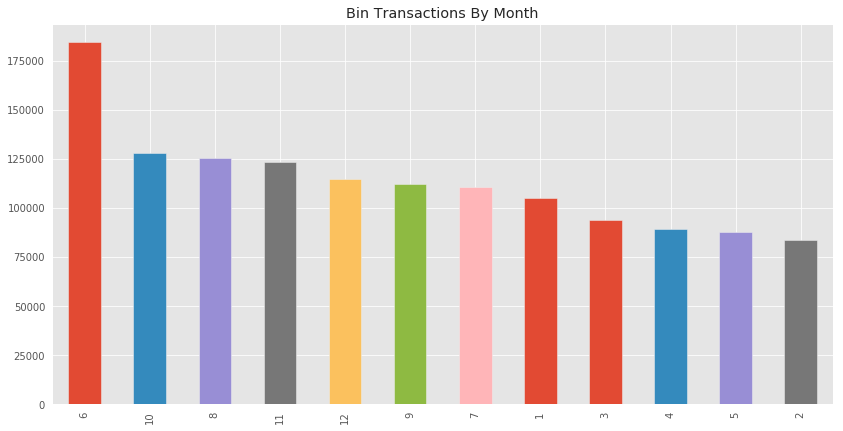

In [32]:
df_bintrans.month.value_counts().plot.bar()
plt.title('Bin Transactions By Month');

In [33]:
#df_bintrans.to_csv('processed/BinTransactions.csv', index=False)

In [34]:
del df_bintrans

## Inventory Transactions
<a id='Inventory_Transactions'></a>


[Table of Contents](#Table_of_Contents)

In [35]:
df_invtrans = pd.read_csv('data/InventoryTransactions.csv', index_col = None, header = 0, low_memory=False)

In [36]:
df_invtrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076857 entries, 0 to 3076856
Data columns (total 11 columns):
source      object
line_no     int64
lev_no      int64
seq_no      int64
item_no     object
loc         object
trx_tm      object
doc_type    object
year        int64
month       int64
day         int64
dtypes: int64(6), object(5)
memory usage: 258.2+ MB


In [37]:
df_invtrans.head(3)

,source,line_no,lev_no,seq_no,item_no,loc,trx_tm,doc_type,year,month,day
0,B,0,0,0,08020,TRN,1900-01-01 17:40:57.707,H,2017,8,31
1,B,0,0,1,080206,01,1900-01-01 17:40:57.707,H,2017,8,31
2,B,0,0,2,080206,TRN,1900-01-01 17:40:57.707,H,2017,8,31


In [38]:
df_invtrans['YMD'] = pd.to_datetime(df_invtrans['year month day'.split(' ')])

In [39]:
df_invtrans.nunique()

source            6
line_no         186
lev_no           10
seq_no         7129
item_no       15094
loc              25
trx_tm      1073080
doc_type         11
year              5
month            12
day              31
YMD            1089
dtype: int64

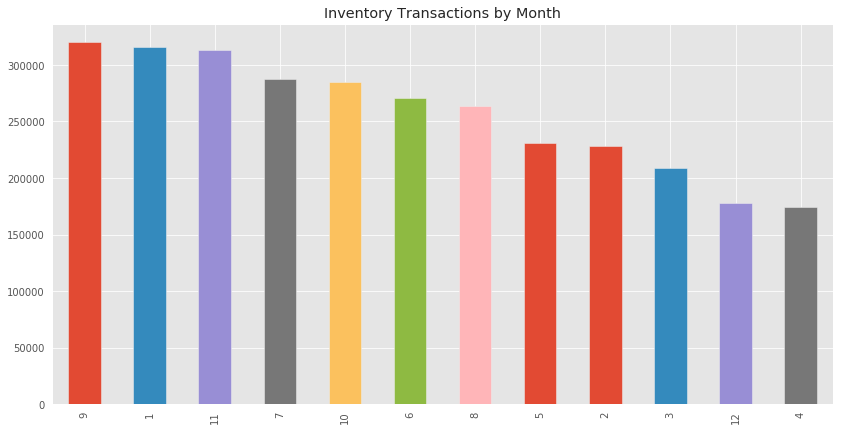

In [40]:
df_invtrans.month.value_counts().plot.bar()
plt.title('Inventory Transactions by Month');

In [41]:
#df_invtrans.to_csv('processed/InventoryTransactions.csv', index=False)

In [42]:
del df_invtrans

## Order Header
<a id='Order_Header'></a>


[Table of Contents](#Table_of_Contents)

In [43]:
df_order = pd.read_csv('data/Orders.csv', index_col = None, header = 0, low_memory=False)

In [44]:
dt = df_order.dtypes


In [45]:
df_order.ord_dt.unique()[:10]

array(['2015-11-18', '2015-12-17', '2015-07-14', '2016-09-23',
       '2016-09-27', '2016-11-10', '2018-07-26', '2016-03-04',
       '2018-09-24', '2017-02-17'], dtype=object)

In [46]:
ddt = pd.to_datetime(df_order.ord_dt)
print(ddt[:10])
dt = ddt[0]
'dt.year is a {}'.format(dt.year.__class__)

0   2015-11-18
1   2015-12-17
2   2015-07-14
3   2015-07-14
4   2016-09-23
5   2016-09-27
6   2016-11-10
7   2016-11-10
8   2016-11-10
9   2016-11-10
Name: ord_dt, dtype: datetime64[ns]


"dt.year is a <class 'int'>"

In [47]:
df_orderheader = pd.read_csv('data/OrderHeader.csv', index_col = None, header = 0, low_memory=False)


In [48]:
df_orderheader = df_orderheader.join(df_order['ord_day ord_month ord_week ord_dayname'.split(' ')], on='ord_no')
df_orderheader.head()


,ord_no,apply_to_no,oe_po_no,cus_no,bal_meth,bill_to_name,bill_to_addr_1,bill_to_addr_2,bill_to_addr_3,bill_to_addr_city,bill_to_state,bill_to_addr_zip,ar_terms_cd,frt_pay_cd,slspsn_no,slspsn_pct_comm,slspsn_comm_amt,slspsn_no_2,slspsn_pct_comm_2,slspsn_comm_amt_2,mfg_loc,ord_day,ord_month,ord_week,ord_dayname
0,176761,0.0,16-012,2557,O,BurksMiddle School;Putnam Co Board of Ed,300 Crossville Street,NaN,NaN,Duquesne,PA,15110,US,00:00.0,N,NaN,NaN,57,100,0.0,0,2.0,5.0,20.0,Wednesday
1,178104,0.0,16-012,2557,O,BurksMiddle School;Putnam Co Board of Ed,300 Crossville Street,NaN,NaN,Duquesne,PA,15110,US,00:00.0,N,NaN,NaN,57,100,0.0,0,1.0,4.0,17.0,Tuesday
2,170884,0.0,,530,O,Good Samaritan/Manchester,PO Box 281,NaN,NaN,Sharon,PA,16146,US,00:00.0,N,K-55338,NaN,57,100,0.0,0,3.0,9.0,36.0,Thursday
3,197249,NaN,,429,O,Nashville Inner City Ministries,1000 Apex Drive,NaN,96 Laurel Hill Road,Verona,VA,24482,US,NaN,N,NaN,NaN,57,100,0.0,0,1.0,9.0,37.0,Tuesday
4,202861,NaN,todd,429,O,Nashville Inner City Ministries,1000 Apex Drive,NaN,96 Laurel Hill Road,Verona,VA,24482,US,NaN,N,Post- Backorder PO 66987,NaN,57,100,0.0,0,4.0,11.0,46.0,Friday


In [49]:
df_orderheader.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56850 entries, 0 to 56849
Data columns (total 25 columns):
ord_no               56850 non-null int64
apply_to_no          16561 non-null float64
oe_po_no             56850 non-null object
cus_no               56850 non-null object
bal_meth             56850 non-null object
bill_to_name         56848 non-null object
bill_to_addr_1       54974 non-null object
bill_to_addr_2       9276 non-null object
bill_to_addr_3       249 non-null object
bill_to_addr_city    55555 non-null object
bill_to_state        56751 non-null object
bill_to_addr_zip     55407 non-null object
ar_terms_cd          56143 non-null object
frt_pay_cd           56750 non-null object
slspsn_no            4711 non-null object
slspsn_pct_comm      35252 non-null object
slspsn_comm_amt      54365 non-null object
slspsn_no_2          56526 non-null object
slspsn_pct_comm_2    56618 non-null object
slspsn_comm_amt_2    56815 non-null float64
mfg_loc              55446 non-nul

In [50]:
df_orderheader.nunique()

ord_no               56843
apply_to_no           1182
oe_po_no              4070
cus_no                1067
bal_meth                 5
bill_to_name          2343
bill_to_addr_1        1298
bill_to_addr_2         189
bill_to_addr_3          10
bill_to_addr_city      344
bill_to_state           57
bill_to_addr_zip       389
ar_terms_cd             51
frt_pay_cd              41
slspsn_no              575
slspsn_pct_comm         80
slspsn_comm_amt         64
slspsn_no_2             83
slspsn_pct_comm_2       15
slspsn_comm_amt_2        8
mfg_loc                 18
ord_day                  7
ord_month               12
ord_week                53
ord_dayname              7
dtype: int64

    9 months constitute 80.0% of orders and 75.0% of item


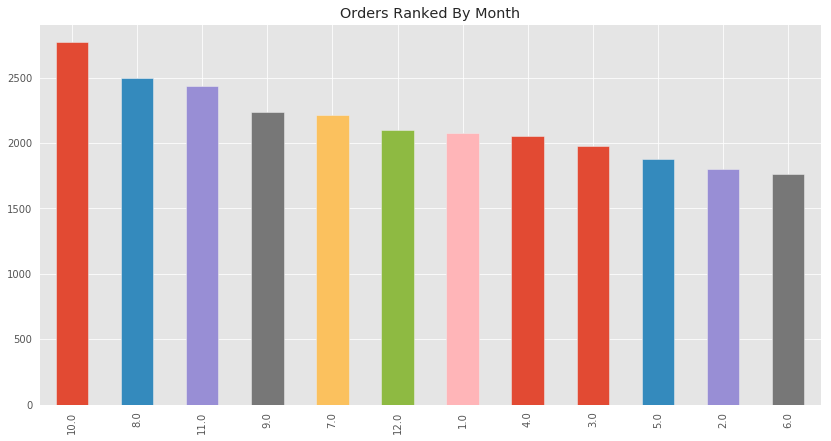

In [51]:
ol = calcPareto(df_orderheader, 'ord_month')
max_pct = 0.8

print('{:5,d} months constitute {:.1%} of orders and {:.1%} of item'.format(sum(ol.cum_pct <= max_pct), max_pct,
                                                                           sum(ol.cum_pct <= max_pct) / len(ol)))
df_orderheader.ord_month.value_counts().plot.bar()
plt.title('Orders Ranked By Month');

In [52]:
vc = sorted(df_orderheader.ord_day.value_counts().items())
vc

[(0.0, 4748),
 (1.0, 6515),
 (2.0, 5709),
 (3.0, 4830),
 (4.0, 2936),
 (5.0, 587),
 (6.0, 482)]

In [53]:
day_dict = dict(zip(range(7), 'mon tue wed thur fri sat sun'.split(" ")))
[(day_dict[d], v) for d, v in df_orderheader.ord_day.value_counts().items()]

[('tue', 6515),
 ('wed', 5709),
 ('thur', 4830),
 ('mon', 4748),
 ('fri', 2936),
 ('sat', 587),
 ('sun', 482)]

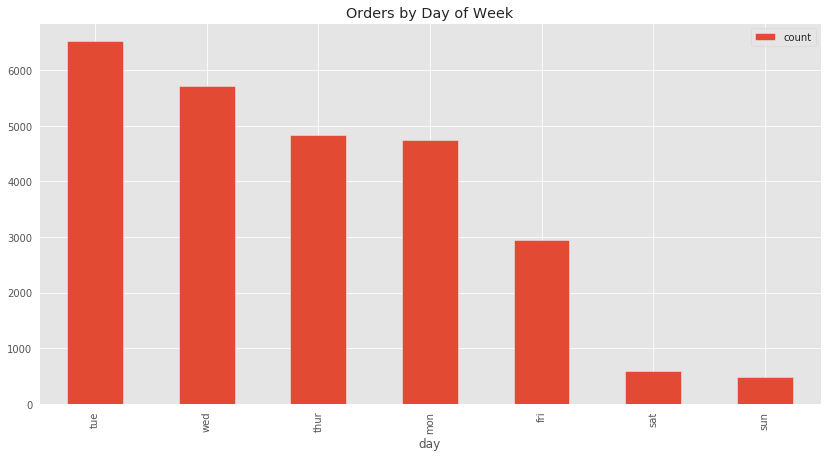

In [54]:
ord_day = pd.DataFrame([(day_dict[d], v) for d, v in df_orderheader.ord_day.value_counts().items()], columns='day count'.split(' '))
ord_day.set_index(keys='day', drop=True, inplace=True)
ord_day.plot.bar()
plt.title('Orders by Day of Week');

In [55]:
order_pareto = calcPareto(df_orderheader, 'bill_to_name')
order_pareto.head(100)

,counter,pct_count,cum_pct
bill_to_name,,,
Christian Coop. Ministry,610,0.010730,0.010730
Martha O'Bryan Center EFB,600,0.010554,0.021285
Manna Cafe Ministries,498,0.008760,0.030045
The Branch,487,0.008567,0.038612
Bridge Ministries The,476,0.008373,0.046985
MAIN WAREHOUSE a/r,469,0.008250,0.055235
St. Luke's Community House EFB,438,0.007705,0.062940
Here Am I Missions,420,0.007388,0.070328
The Little Pantry That Could,404,0.007107,0.077435


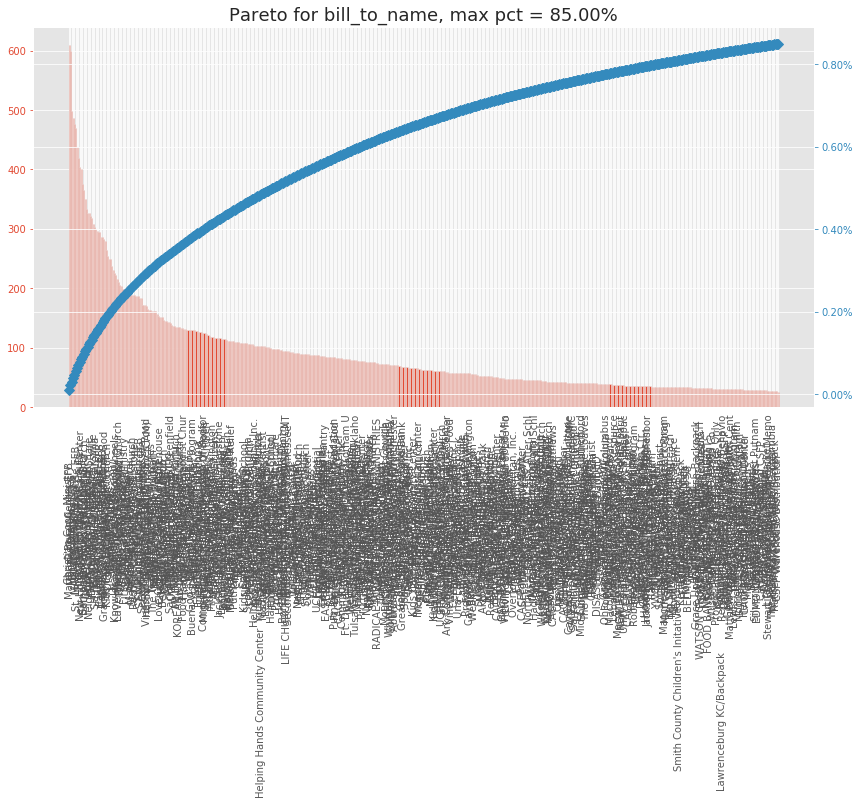

In [56]:
plotPareto(df_orderheader, 'bill_to_name')

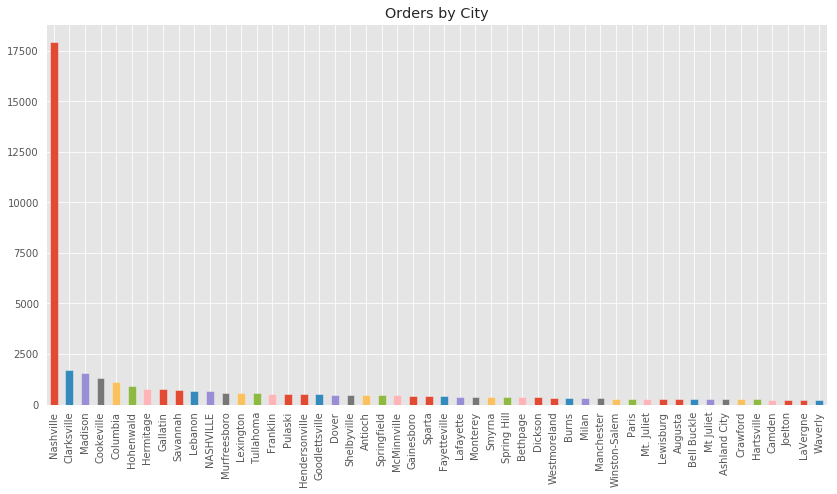

In [57]:
hv = df_orderheader.bill_to_addr_city.value_counts().head(50).plot.bar()
plt.title('Orders by City');


In [58]:
df_orderheader.nunique()

ord_no               56843
apply_to_no           1182
oe_po_no              4070
cus_no                1067
bal_meth                 5
bill_to_name          2343
bill_to_addr_1        1298
bill_to_addr_2         189
bill_to_addr_3          10
bill_to_addr_city      344
bill_to_state           57
bill_to_addr_zip       389
ar_terms_cd             51
frt_pay_cd              41
slspsn_no              575
slspsn_pct_comm         80
slspsn_comm_amt         64
slspsn_no_2             83
slspsn_pct_comm_2       15
slspsn_comm_amt_2        8
mfg_loc                 18
ord_day                  7
ord_month               12
ord_week                53
ord_dayname              7
dtype: int64

In [59]:
order_pareto = calcPareto(df_orderheader, 'mfg_loc')
order_pareto

,counter,pct_count,cum_pct
mfg_loc,,,
1,44314,0.799228,0.799228
99,2961,0.053403,0.852631
0,2732,0.049273,0.901905
206,2424,0.043718,0.945623
500,1509,0.027216,0.972838
406,650,0.011723,0.984562
103,213,0.003842,0.988403
68,194,0.003499,0.991902
390,184,0.003319,0.995221


In [60]:
#df_orderheader.to_csv('processed/OrderHeader.csv', index=False)

In [61]:
try:
    del df_orderheader
except:
    pass

## Order Line Details
<a id='Order_Line_Details'></a>


[Table of Contents](#Table_of_Contents)

In [62]:
df_orderline = pd.read_csv('data/OrderLine.csv', index_col = None, header = 0, low_memory=False)

In [63]:
df_itemmaster = pd.read_csv('data/DR_ItemMaster.csv', index_col = None, header = 0, low_memory=False)
df_itemmaster.drop(['commodity_cd', 'ID'], axis=1, inplace=True)
rename_dict = dict([('user_def_fld_4', 'food_pyramid')])
rename_dict
df_itemmaster.rename(columns=rename_dict, inplace=True)
df_itemmaster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3437 entries, 0 to 3436
Data columns (total 12 columns):
item_no            3437 non-null object
item_desc_1        3437 non-null object
item_desc_2        3424 non-null object
prod_cat           3437 non-null object
uom                3436 non-null object
item_weight_uom    3420 non-null object
item_weight        3437 non-null float64
p_and_ic_cd        3153 non-null object
item_note_3        1620 non-null object
item_note_4        2935 non-null object
item_note_5        3393 non-null object
food_pyramid       3259 non-null object
dtypes: float64(1), object(11)
memory usage: 322.3+ KB


In [64]:
df_orderline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412075 entries, 0 to 412074
Data columns (total 11 columns):
ord_type             412075 non-null object
ord_no               412075 non-null int64
line_seq_no          412075 non-null int64
item_no              412075 non-null object
loc                  412075 non-null int64
item_desc_1          411854 non-null object
item_desc_2          411631 non-null object
qty_ordered          412075 non-null float64
prc_cd_orig_price    412072 non-null float64
cus_no               412075 non-null int64
ID                   412072 non-null float64
dtypes: float64(3), int64(4), object(4)
memory usage: 34.6+ MB


In [65]:
df_orderline = df_orderline.merge(df_itemmaster, on='item_no', how='inner')

In [66]:
df_orderline['item_no'] = df_orderline.item_no.apply(lambda x: x.strip()) # some extra spaces at end to remove
ln = df_orderline.item_no.unique()

In [67]:
df_orderline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139387 entries, 0 to 139386
Data columns (total 22 columns):
ord_type             139387 non-null object
ord_no               139387 non-null int64
line_seq_no          139387 non-null int64
item_no              139387 non-null object
loc                  139387 non-null int64
item_desc_1_x        139313 non-null object
item_desc_2_x        139297 non-null object
qty_ordered          139387 non-null float64
prc_cd_orig_price    139384 non-null float64
cus_no               139387 non-null int64
ID                   139384 non-null float64
item_desc_1_y        139387 non-null object
item_desc_2_y        139288 non-null object
prod_cat             139387 non-null object
uom                  139387 non-null object
item_weight_uom      139387 non-null object
item_weight          139387 non-null float64
p_and_ic_cd          139195 non-null object
item_note_3          104419 non-null object
item_note_4          122384 non-null object
item_note

In [68]:
df_orderline.nunique()

ord_type                  1
ord_no                36427
line_seq_no             147
item_no                 316
loc                      13
item_desc_1_x           378
item_desc_2_x           288
qty_ordered            1403
prc_cd_orig_price      2933
cus_no                  997
ID                   139384
item_desc_1_y           301
item_desc_2_y           151
prod_cat                 30
uom                       3
item_weight_uom           3
item_weight              78
p_and_ic_cd               2
item_note_3               3
item_note_4              43
item_note_5             118
food_pyramid              4
dtype: int64

In [69]:
ol = calcPareto(df_orderline, 'item_no')
max_pct = 0.8

print('{:5,d} items constitute {:.1%} of orders and {:.1%} of item'.format(sum(ol.cum_pct <= max_pct), max_pct,
                                                                           sum(ol.cum_pct <= max_pct) / len(ol)))


   58 items constitute 80.0% of orders and 18.4% of item


In [70]:
ol.columns

Index(['counter', 'pct_count', 'cum_pct'], dtype='object')

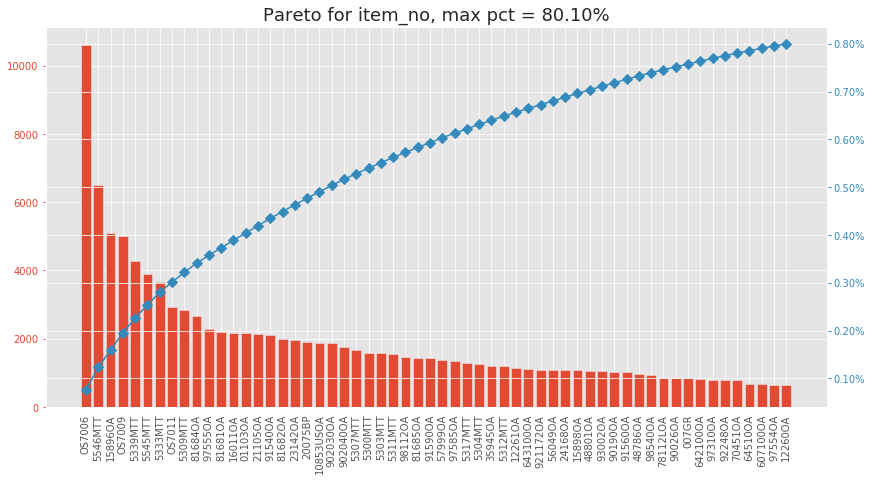

In [71]:
plotPareto(df_orderline, 'item_no', max_pct=0.801) # pretty crowded even at 70% but a smooth curve

In [72]:
#df_orderline.to_csv('processed/OrderLine.csv', index=False)

In [73]:
del df_orderline

## Customer and Vendor info
<a id='Customer_and_Vendor_info'></a>

Not interesting

[Table of Contents](#Table_of_Contents)

In [74]:
df_custvendor = pd.read_csv('data/CustomerandVendor.csv', index_col = None, header = 0, low_memory=False)

In [75]:
df_custvendor.head(3)

,cus_no,cmp_name,Address,City,StateCode,ZipCode
0,10090.0,Simon's Produce ...,777 Clay Cole Rd,Elkton,KY,NaN
1,3474.0,Allen Lund Company LLC ...,PO Box 51083,Los Angeles,CA,90051
2,9390.0,"Escreen, Inc. ...","7500 W 110th Street, Suite 500",Overland Park,KS,66210


In [76]:
df_custvendor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9058 entries, 0 to 9057
Data columns (total 6 columns):
cus_no       7903 non-null float64
cmp_name     9058 non-null object
Address      8951 non-null object
City         9044 non-null object
StateCode    9018 non-null object
ZipCode      6561 non-null object
dtypes: float64(1), object(5)
memory usage: 424.7+ KB


In [77]:
#df_custvendor.to_csv('processed/CustomerandVendor.csv', index=False)

In [78]:
del df_custvendor

## Item Inventory by Bin and Location
<a id='Item_Inventory_by_Bin_and_Location'></a>

Not interesting


[Table of Contents](#Table_of_Contents)

In [79]:
df_iteminvbinloc = pd.read_csv('data/ItemInvBinLoc.csv', index_col = None, header = 0, low_memory=False)

In [80]:
df_iteminvbinloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92091 entries, 0 to 92090
Data columns (total 13 columns):
item_no           92091 non-null object
loc               92091 non-null int64
bin_no            92091 non-null object
bin_priority      92091 non-null int64
issue_priority    92091 non-null object
unit_cost         92091 non-null float64
orig_cost         92091 non-null float64
qty_on_hand       92091 non-null int64
qty_allocated     92091 non-null int64
qty_on_ord        92091 non-null int64
frz_cost          92091 non-null float64
frz_qty           92091 non-null int64
ID                92091 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 9.1+ MB


In [81]:
df_iteminvbinloc.nunique()

item_no            3457
loc                   9
bin_no             4585
bin_priority          3
issue_priority     4854
unit_cost          9038
orig_cost          8154
qty_on_hand        1018
qty_allocated       126
qty_on_ord            1
frz_cost            999
frz_qty             497
ID                92091
dtype: int64

In [82]:
#df_iteminvbinloc.to_csv('processed/ItemInvBinLoc.csv', index=False)

In [83]:
del df_iteminvbinloc

## Item Inventory by Location
<a id='Item_Inventory_by_Location'></a>

Not interesting

[Table of Contents](#Table_of_Contents)

In [84]:
df_iteminvloc = pd.read_csv('data/ItemInvLoc.csv', index_col = None, header = 0, low_memory=False)

In [85]:
df_iteminvloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33842 entries, 0 to 33841
Data columns (total 14 columns):
item_no           33842 non-null object
loc               33842 non-null object
status            33842 non-null object
mult_bin_fg       33842 non-null object
qty_on_hand       33842 non-null int64
qty_allocated     33842 non-null int64
reorder_lvl       33842 non-null int64
price             33842 non-null float64
avg_cost          33842 non-null float64
last_cost         33842 non-null float64
std_cost          33842 non-null float64
qty_last_sold     33842 non-null int64
cycle_count_cd    14334 non-null object
inv_class         33841 non-null object
dtypes: float64(4), int64(4), object(6)
memory usage: 3.6+ MB


In [86]:
df_iteminvloc.nunique()

item_no           14366
loc                  25
status                1
mult_bin_fg           2
qty_on_hand         571
qty_allocated       335
reorder_lvl         167
price              1646
avg_cost           3124
last_cost          2361
std_cost           1749
qty_last_sold       666
cycle_count_cd        4
inv_class             3
dtype: int64

In [87]:
df_iteminvloc.head(3)

,item_no,loc,status,mult_bin_fg,qty_on_hand,qty_allocated,reorder_lvl,price,avg_cost,last_cost,std_cost,qty_last_sold,cycle_count_cd,inv_class
0,1,1,A,Y,0,0,0,0.0,0.0,0.0,0.0,0,Z,A
1,1,TRN,A,N,0,0,0,0.0,0.0,0.0,0.0,0,NaN,A
2,2,1,A,Y,0,0,0,0.0,0.0,0.0,0.0,0,Z,A


In [88]:
#df_iteminvloc.to_csv('processed/ItemInvLoc.csv', index=False)

In [89]:
del df_iteminvloc

## Location Description
<a id='Location_Description'></a>

Not interesting

[Table of Contents](#Table_of_Contents)

In [90]:
df_locdescript = pd.read_csv('data/LocationDescription.csv', index_col = None, header = 0, low_memory=False)

In [91]:
df_locdescript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 12 columns):
loc            25 non-null object
loc_desc       25 non-null object
mult_bin_fg    25 non-null object
mrp_fg         25 non-null object
addr_1         24 non-null object
addr_2         23 non-null object
addr_3         0 non-null float64
city           23 non-null object
state          23 non-null object
zip            23 non-null float64
country        24 non-null object
phone_no       15 non-null object
dtypes: float64(2), object(10)
memory usage: 2.4+ KB


In [92]:
df_locdescript.nunique()

loc            25
loc_desc       25
mult_bin_fg     2
mrp_fg          1
addr_1         15
addr_2         15
addr_3          0
city            8
state           3
zip            12
country         1
phone_no       10
dtype: int64

In [93]:
df_locdescript.head(3)

,loc,loc_desc,mult_bin_fg,mrp_fg,addr_1,addr_2,addr_3,city,state,zip,country,phone_no
0,1,Main Warehouse,Y,N,Second Harvest Food Bank of Middle TN,331 Great Circle Road,NaN,Nashville,TN,37228.0,US,615-627-1596
1,3,SALVAGE ROOM,N,N,Second Harvest Food Bank of Middle TN,331 Great Circle Rd,NaN,Nashville,TN,37228.0,US,NaN
2,4,Smyrna Salvage,N,N,Second Harvest Food Bank Mid TN Smyrna,1958 Almaville Road,NaN,Smyrna,TN,37167.0,US,615-365-9950


In [94]:
#df_locdescript.to_csv('processed/LocationDescription.csv', index=False)

In [95]:
del df_locdescript